# Corr of RT Difference (Simulated) and Parameters (Simulated)

In [1]:
import sys
import os

SCRIPT_PATH = os.path.join(os.path.abspath(os.path.dirname('../__file__')), 'script')
sys.path.insert(0, SCRIPT_PATH)


from markov_pyactup import *
from statsmodels.formula.api import logit, glm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import pyactup as pau


main_dir = os.path.dirname(os.path.realpath('../__file__'))
main_dir = os.path.dirname(os.getcwd())
subject_dir = os.path.join(main_dir, 'data', 'human', 'online_data')

opt_dir = os.path.join(main_dir, 'data', 'model', 'param_optimization_0403')
dest_dir = os.path.join(main_dir, 'data', 'model', 'param_effect')

sns.set(font_scale=2)
sns.set_style("white")

ACT-R connection has been started.


In [2]:
def plot_rt_parameter(df, param_name):

    df['response_time_mean'] = df.apply(lambda x: 1000*(x['state1_response_time_mean'] + x['state2_response_time_mean']), axis=1)
    df_wide = df[['epoch', param_name, 'pre_received_reward', 'pre_state_frequency', 'response_time_mean']].pivot(index=['epoch', param_name, 'pre_received_reward'], columns=['pre_state_frequency'], values=['response_time_mean']).reset_index()
    df_wide[('response_time_diff')] = df_wide[('response_time_mean', 'rare')]-df_wide[('response_time_mean', 'common')]
    df_wide = df_wide.drop(columns=[('response_time_mean', 'rare'), ('response_time_mean', 'common')])
    df_wide.columns = [c[0] for c in df_wide.columns]
    df_wide = df_wide.groupby([param_name,'pre_received_reward'])['response_time_diff'].mean().reset_index()
    
    g = sns.lmplot(data=df_wide, x='response_time_diff', y=param_name, height=6, aspect=1.5, x_jitter=.5, y_jitter=.5,
               scatter_kws={'s':200, 'alpha':0.7, 'color':'black'}, line_kws={'lw':5})
    g.map_dataframe(MarkovPlot.annotate, x='response_time_diff', y=param_name)

    fig = g.fig
    fig.suptitle('')
    ax = fig.axes[0] 
    ax.set_title("ACT-R Hyrbid Model Simulation") 
    ax.set_xlabel('Response Time Difference\n (Rare - Common) (ms)')
    ax.set_ylabel('parameter: %s' % param_name)
    plt.show()

## lf and RT (Rare - Common)

Below plot reveals the correlation between `lf` parameter and response time difference between common and rare trials

Note: this is not emeprical data, not optimized data, but simulation data. The data are simulated by fixing all other parameters, but varing `lf` from 0 to 1.5, each parameter runing for 100 times (epoch), and each run consists of 200 trials. The simulation data is the response time difference aggregated by `pre_transition_frequency` only

In [3]:
model_name = 'markov-ibl-mb'
param_name = 'lf'
df = MarkovSimulation.simulate_param_effect(model_name=model_name, param_name=param_name, save_output=dest_dir, e=100)

...LOAD...


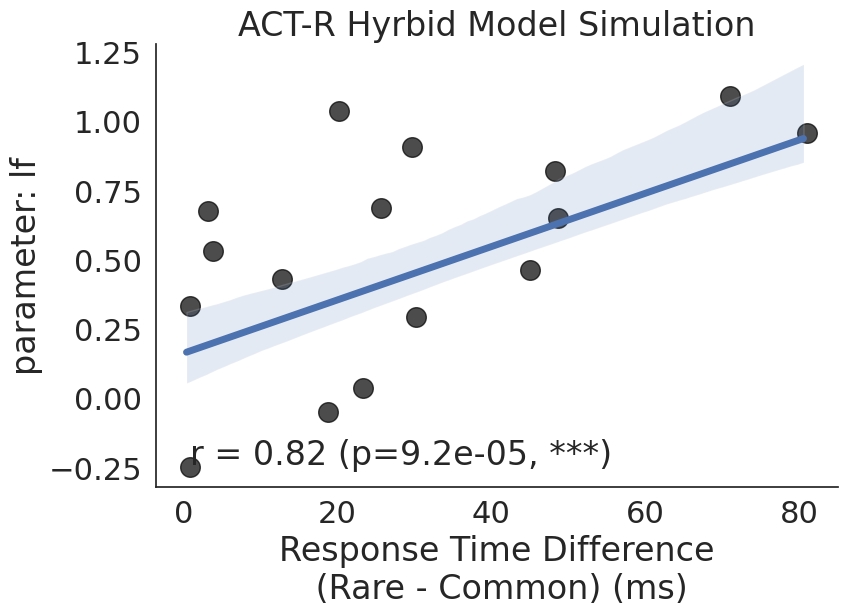

In [4]:
plot_rt_parameter(df,param_name)

## temperature and RT (Rare - Common)

In [5]:
model_name = 'markov-ibl-hybrid'
param_name = 'temperature'
df = MarkovSimulation.simulate_param_effect(model_name=model_name, param_name=param_name, save_output=dest_dir, e=100)

...LOAD...


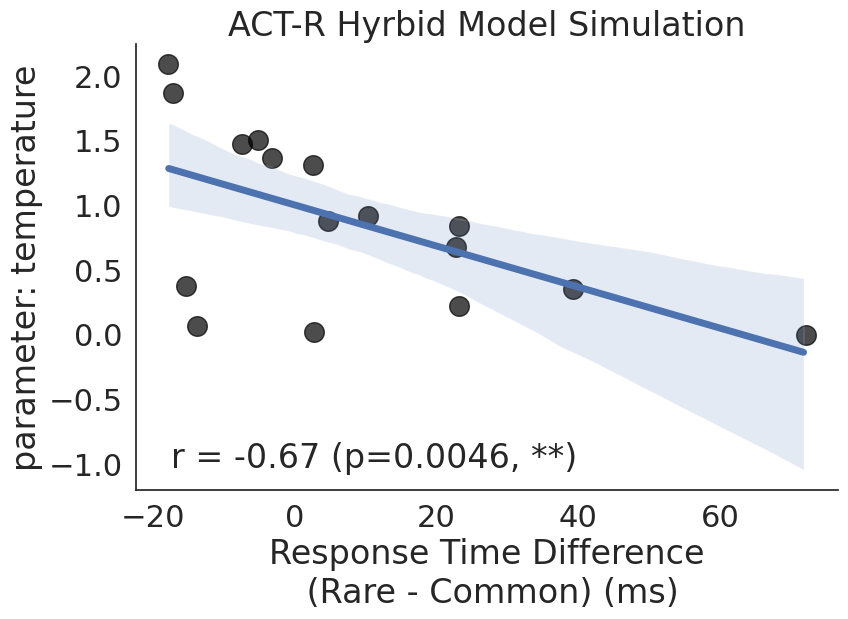

In [6]:
plot_rt_parameter(df,param_name)

## decay and RT (Rare - Common)

In [7]:
model_name = 'markov-ibl-hybrid'
param_name = 'decay'
df = MarkovSimulation.simulate_param_effect(model_name=model_name, param_name=param_name, save_output=dest_dir, e=100)

...LOAD...


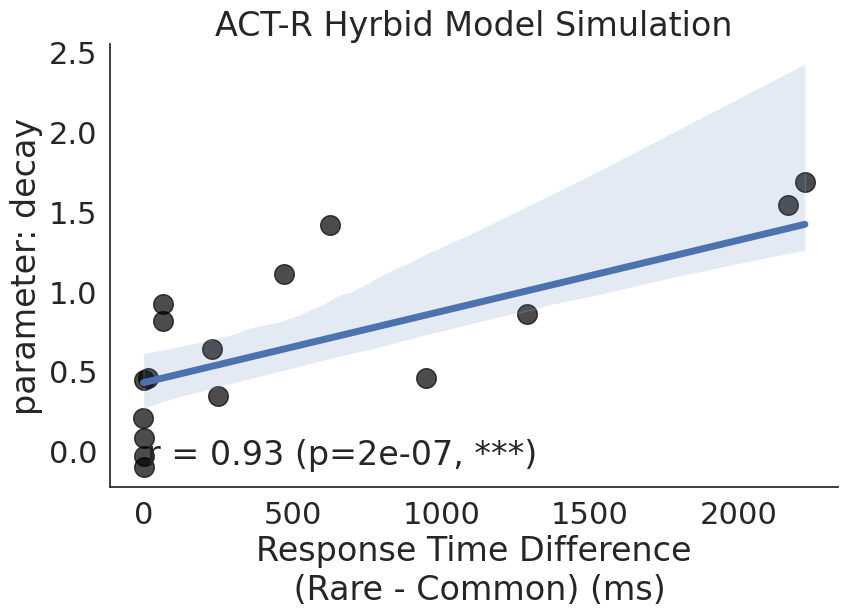

In [8]:
plot_rt_parameter(df,param_name)

# Corr of RT Difference (Human) and Parameters (Optimized)

In this section, we explore the correlation between RT difference (Common-Rare) and optimized parameters. Note, RT here is human data

In [9]:
def calculate_rt_diff(df):
    df['response_time'] = df.apply(lambda x: x['state1_response_time'] + x['state2_response_time'], axis=1)
    df_wide = df.groupby(['subject_id', 'pre_received_reward', 'pre_state_frequency'])['response_time'].mean().reset_index() 
    df_wide = df_wide.pivot(index=['subject_id', 'pre_received_reward'], columns=['pre_state_frequency'], values=['response_time']).reset_index()
    df_wide[('response_time_diff')] = df_wide[('response_time', 'rare')]-df_wide[('response_time', 'common')]
    df_wide = df_wide.drop(columns=[('response_time', 'rare'), ('response_time', 'common')])
    df_wide.columns = [c[0] for c in df_wide.columns]
    return df_wide

In [10]:
# load subject data
dfs = pd.concat([pd.read_csv(f, index_col=0) for f in glob.glob(os.path.join(subject_dir, '*', 'test.csv'))], axis=0).sort_values(by=['subject_id', 'index'])
dfs_wide = calculate_rt_diff(dfs)
dfs_wide.head()

# load optimized parameter data
dfm = MarkovEstimation.load_optimization_data(opt_dir=opt_dir, estimate_models=['markov-ibl-hybrid'], only_maxLL=1)
dfm['subject_id'] = dfm.apply(lambda x:'sub'+str(x['subject_id']), axis=1)

# load subject age data
dfa = pd.read_csv(os.path.join(subject_dir, 'mbmf_ages.csv')) 
dfa.loc[dfa['age'] <= 12.00, 'age_group'] = 'children'
dfa.loc[(dfa['age'] > 12.00) & (dfa['age'] <= 17.00), 'age_group'] = 'adolescent'
dfa.loc[dfa['age'] > 17.00, 'age_group'] = 'adult'
#print(np.unique(dfa[['subject_id', 'age_group']].drop_duplicates()['age_group'], return_counts=True))


dfm = pd.merge(dfm, dfs_wide, on=['subject_id'], how='outer')
dfm = pd.merge(dfm, dfa, on='subject_id', how='left') 

## Corr of Age and Noise

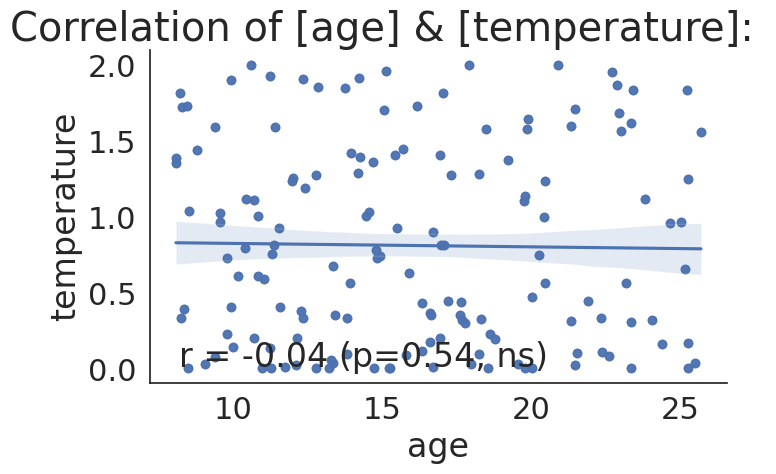

In [11]:
x_name, y_name = 'age', 'temperature'
g = sns.lmplot(data=dfm, x=x_name, y=y_name, height=5, aspect=1.5)
g.map_dataframe(MarkovPlot.annotate, x=x_name, y=y_name)
g.fig.subplots_adjust(top=.9)   
g.fig.suptitle('Correlation of [%s] & [%s]: ' % (x_name, y_name))
plt.show()

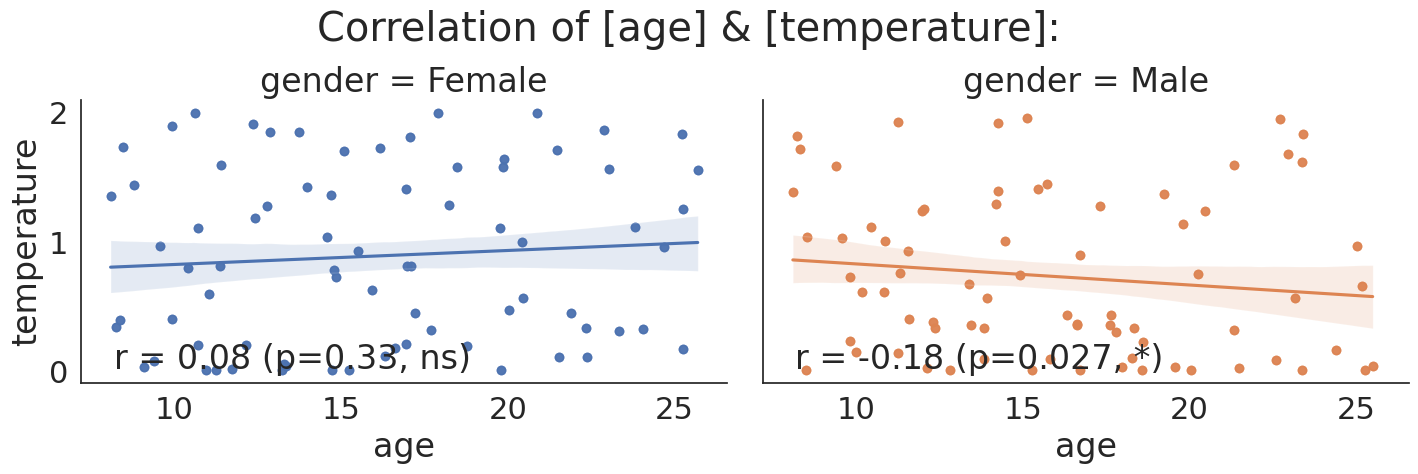

In [12]:
g = sns.lmplot(data=dfm, x=x_name, y=y_name, hue='gender', col='gender', height=5, aspect=1.5)
g.map_dataframe(MarkovPlot.annotate, x=x_name, y=y_name)
g.fig.subplots_adjust(top=.8)   
g.fig.suptitle('Correlation of [%s] & [%s]: ' % (x_name, y_name))
plt.show()

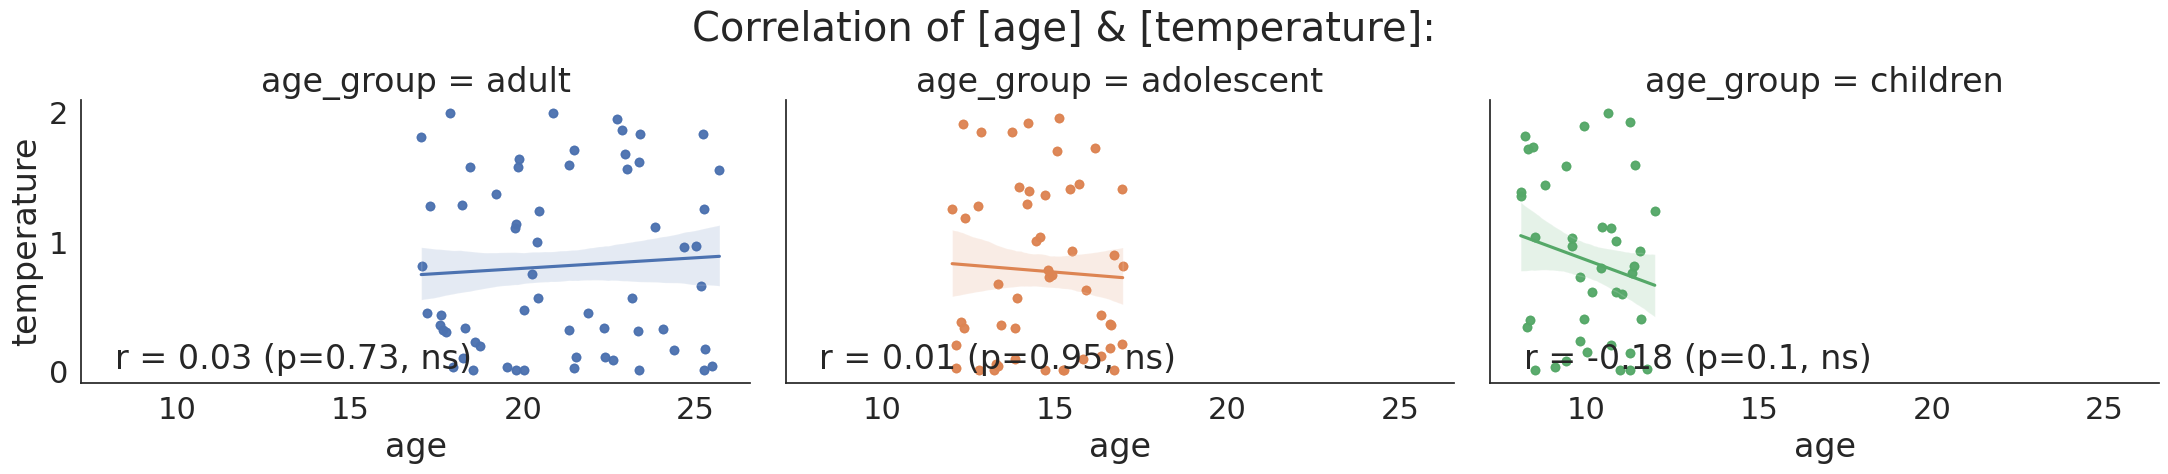

In [14]:
g = sns.lmplot(data=dfm, x=x_name, y=y_name, hue='age_group', col='age_group', height=5, aspect=1.5)
g.map_dataframe(MarkovPlot.annotate, x=x_name, y=y_name)
g.fig.subplots_adjust(top=.8)   
g.fig.suptitle('Correlation of [%s] & [%s]: ' % (x_name, y_name))
plt.show()

## Corr of Age and Decay

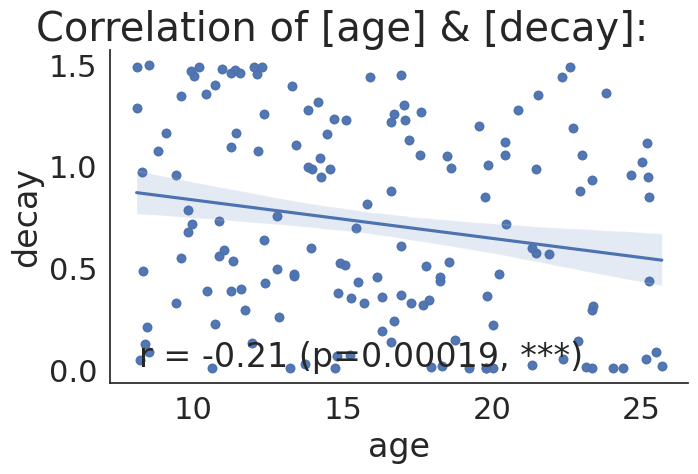

In [15]:
x_name, y_name = 'age', 'decay'
g = sns.lmplot(data=dfm, x=x_name, y=y_name, height=5, aspect=1.5)
g.map_dataframe(MarkovPlot.annotate, x=x_name, y=y_name)
g.fig.subplots_adjust(top=.9)   
g.fig.suptitle('Correlation of [%s] & [%s]: ' % (x_name, y_name))
plt.show()

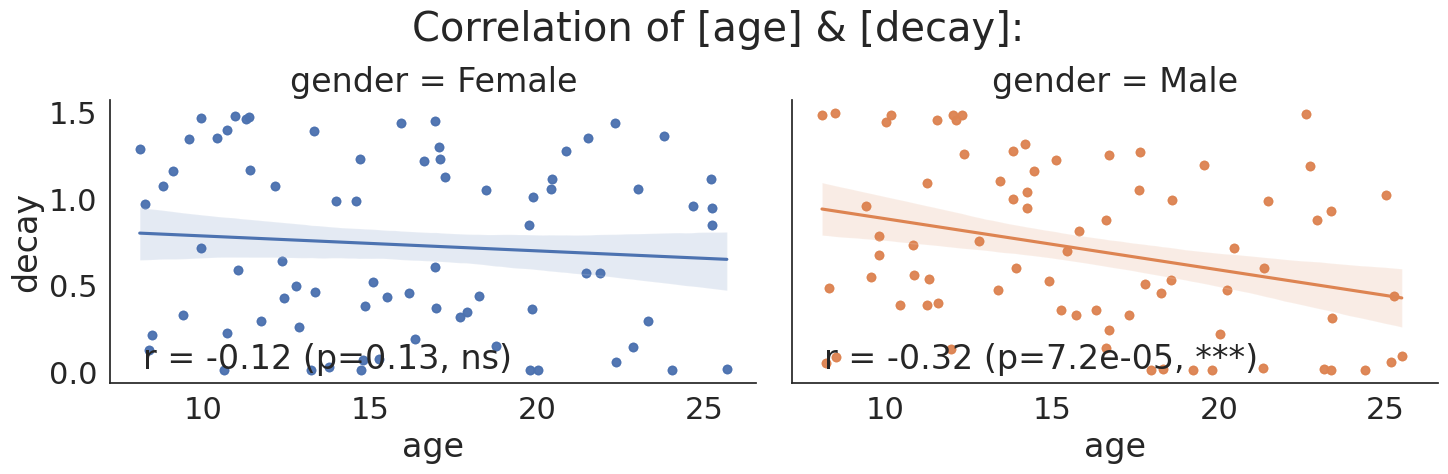

In [16]:
g = sns.lmplot(data=dfm, x=x_name, y=y_name, hue='gender', col='gender', height=5, aspect=1.5)
g.map_dataframe(MarkovPlot.annotate, x=x_name, y=y_name)
g.fig.subplots_adjust(top=.8)   
g.fig.suptitle('Correlation of [%s] & [%s]: ' % (x_name, y_name))
plt.show()

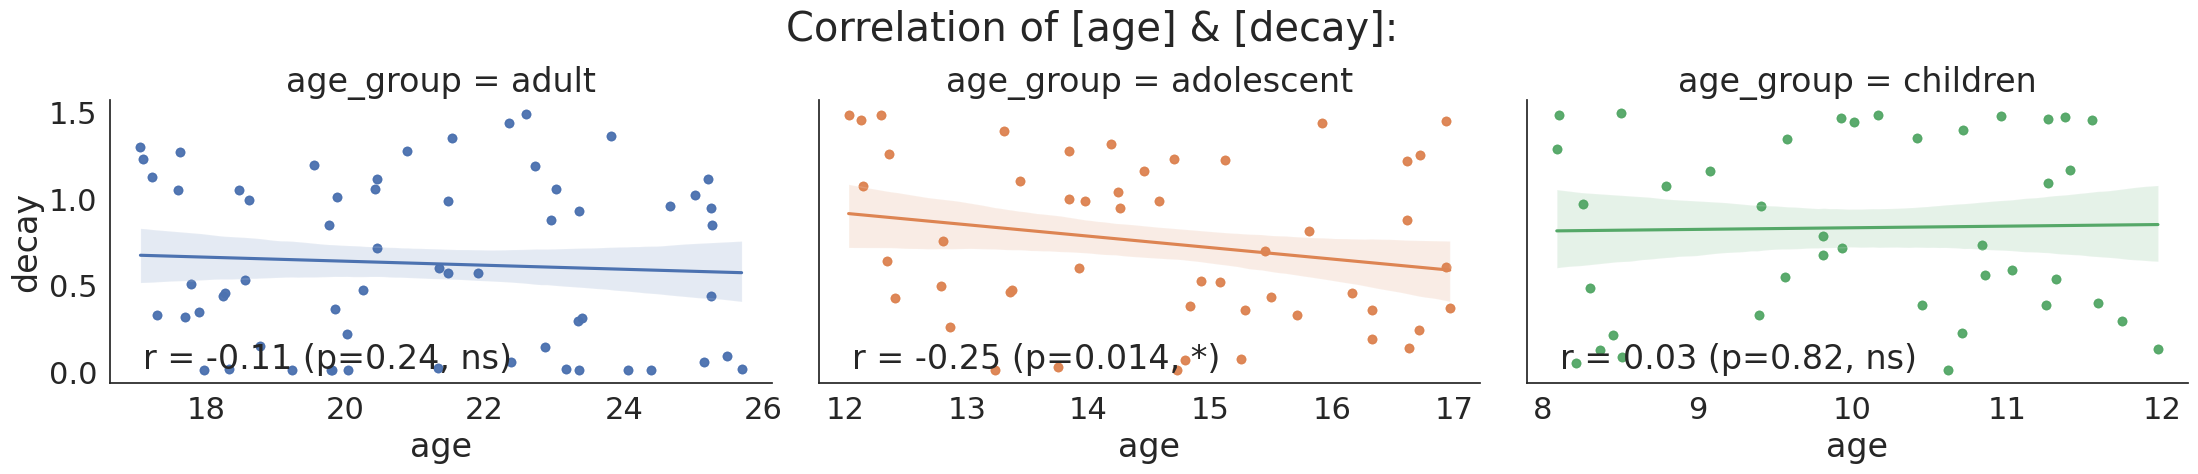

In [17]:
g = sns.lmplot(data=dfm, x=x_name, y=y_name, hue='age_group', col='age_group', height=5, aspect=1.5, facet_kws={'sharex': False})
g.map_dataframe(MarkovPlot.annotate, x=x_name, y=y_name)
g.fig.subplots_adjust(top=.8)   
g.fig.suptitle('Correlation of [%s] & [%s]: ' % (x_name, y_name))
plt.show()

## Corr of RT and Age

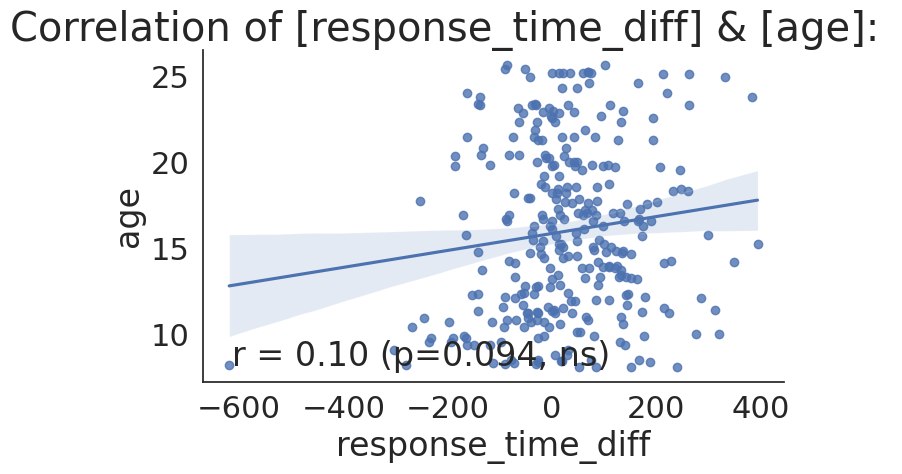

In [18]:
x_name, y_name =  'response_time_diff', 'age'
g = sns.lmplot(data=dfm, x=x_name, y=y_name, height=5, aspect=1.5)
g.map_dataframe(MarkovPlot.annotate, x=x_name, y=y_name)
g.fig.subplots_adjust(top=.9)   
g.fig.suptitle('Correlation of [%s] & [%s]: ' % (x_name, y_name))
plt.show()

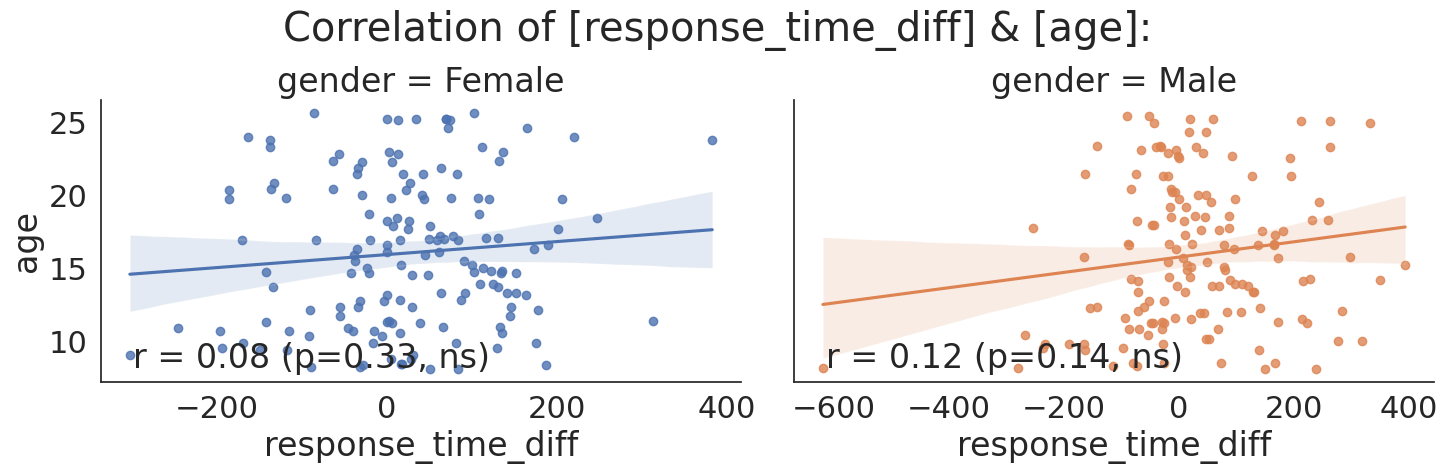

In [19]:
g = sns.lmplot(data=dfm, x=x_name, y=y_name, hue='gender', col='gender', height=5, aspect=1.5, facet_kws={'sharex': False})
g.map_dataframe(MarkovPlot.annotate, x=x_name, y=y_name)
g.fig.subplots_adjust(top=.8)   
g.fig.suptitle('Correlation of [%s] & [%s]: ' % (x_name, y_name))
plt.show()

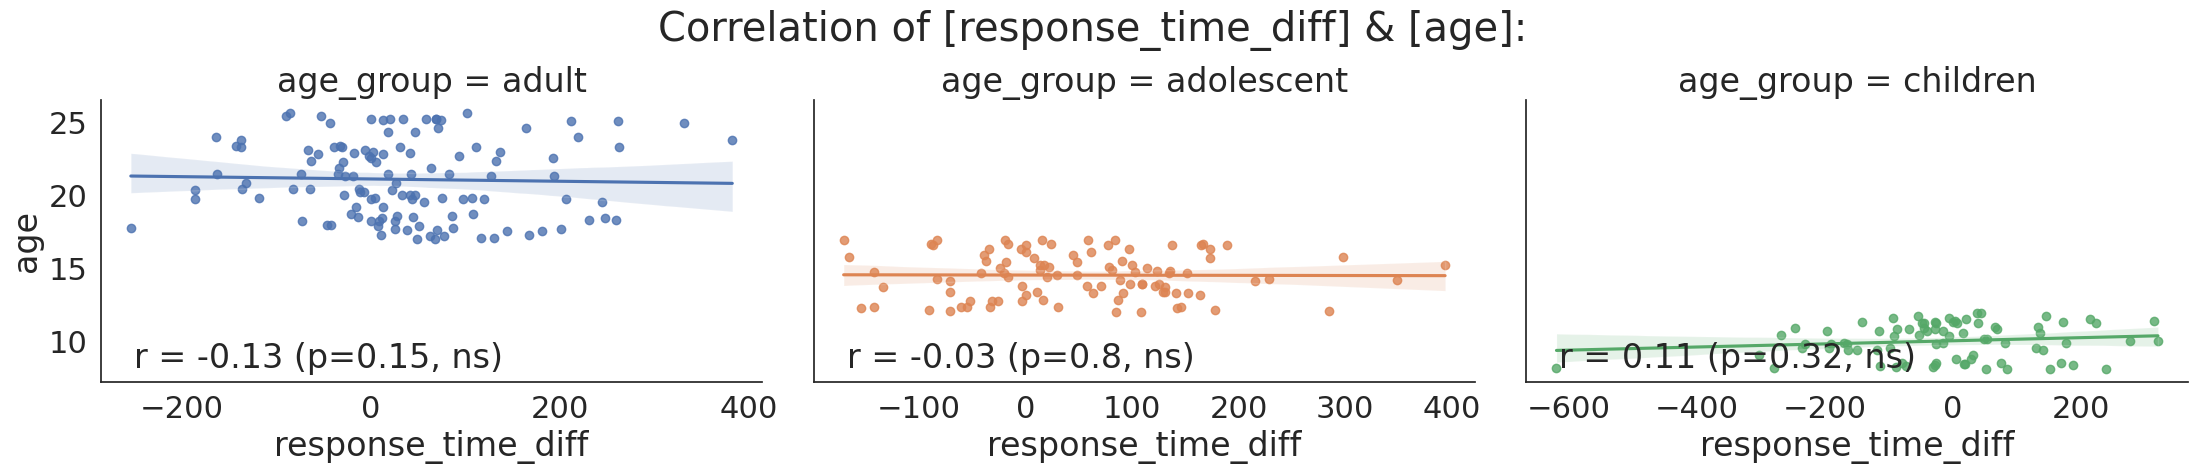

In [20]:
g = sns.lmplot(data=dfm, x=x_name, y=y_name, hue='age_group', col='age_group', height=5, aspect=1.5, facet_kws={'sharex': False})
g.map_dataframe(MarkovPlot.annotate, x=x_name, y=y_name)
g.fig.subplots_adjust(top=.8)   
g.fig.suptitle('Correlation of [%s] & [%s]: ' % (x_name, y_name))
plt.show()

## Corr of RT and Age

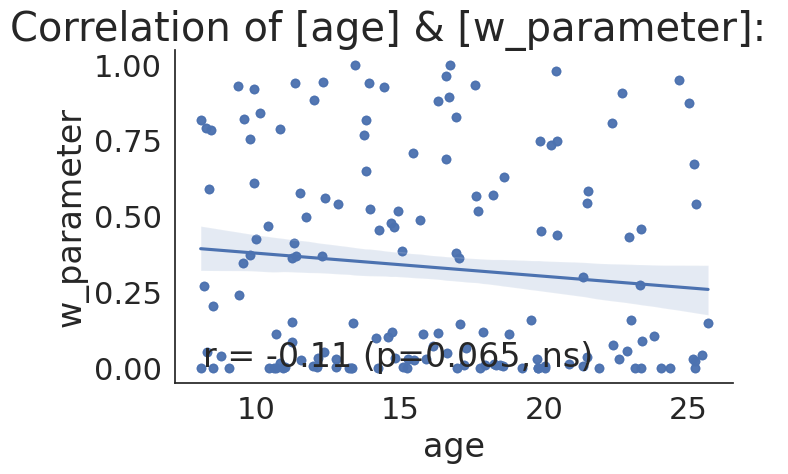

In [22]:
x_name, y_name = 'age', 'w_parameter'
g = sns.lmplot(data=dfm, x=x_name, y=y_name, height=5, aspect=1.5)
g.map_dataframe(MarkovPlot.annotate, x=x_name, y=y_name)
g.fig.subplots_adjust(top=.9)   
g.fig.suptitle('Correlation of [%s] & [%s]: ' % (x_name, y_name))
plt.show()

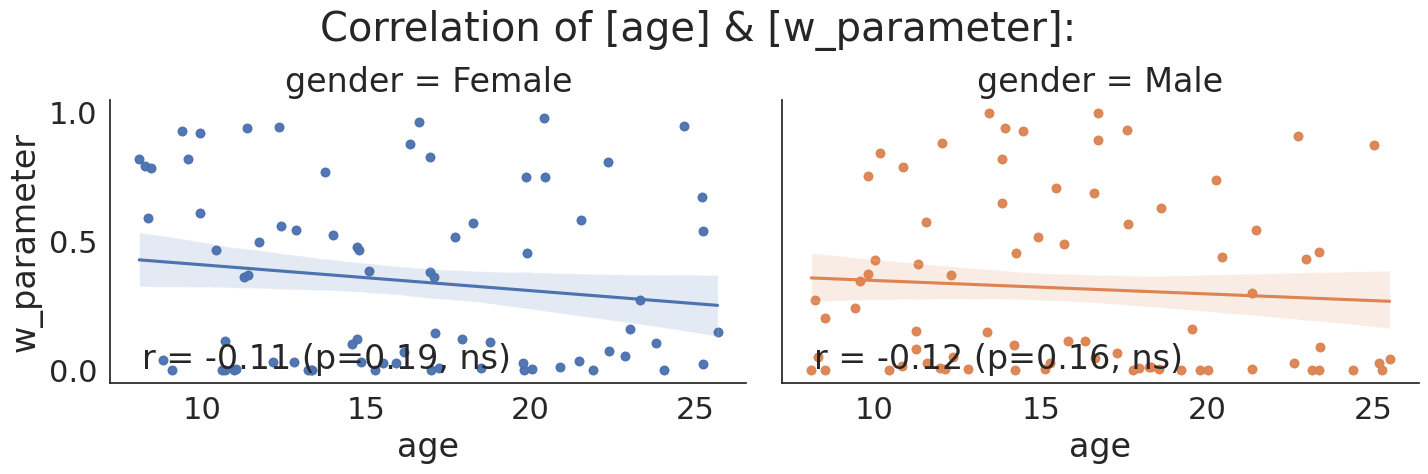

In [23]:
g = sns.lmplot(data=dfm, x=x_name, y=y_name, hue='gender', col='gender', height=5, aspect=1.5, facet_kws={'sharex': False})
g.map_dataframe(MarkovPlot.annotate, x=x_name, y=y_name)
g.fig.subplots_adjust(top=.8)   
g.fig.suptitle('Correlation of [%s] & [%s]: ' % (x_name, y_name))
plt.show()

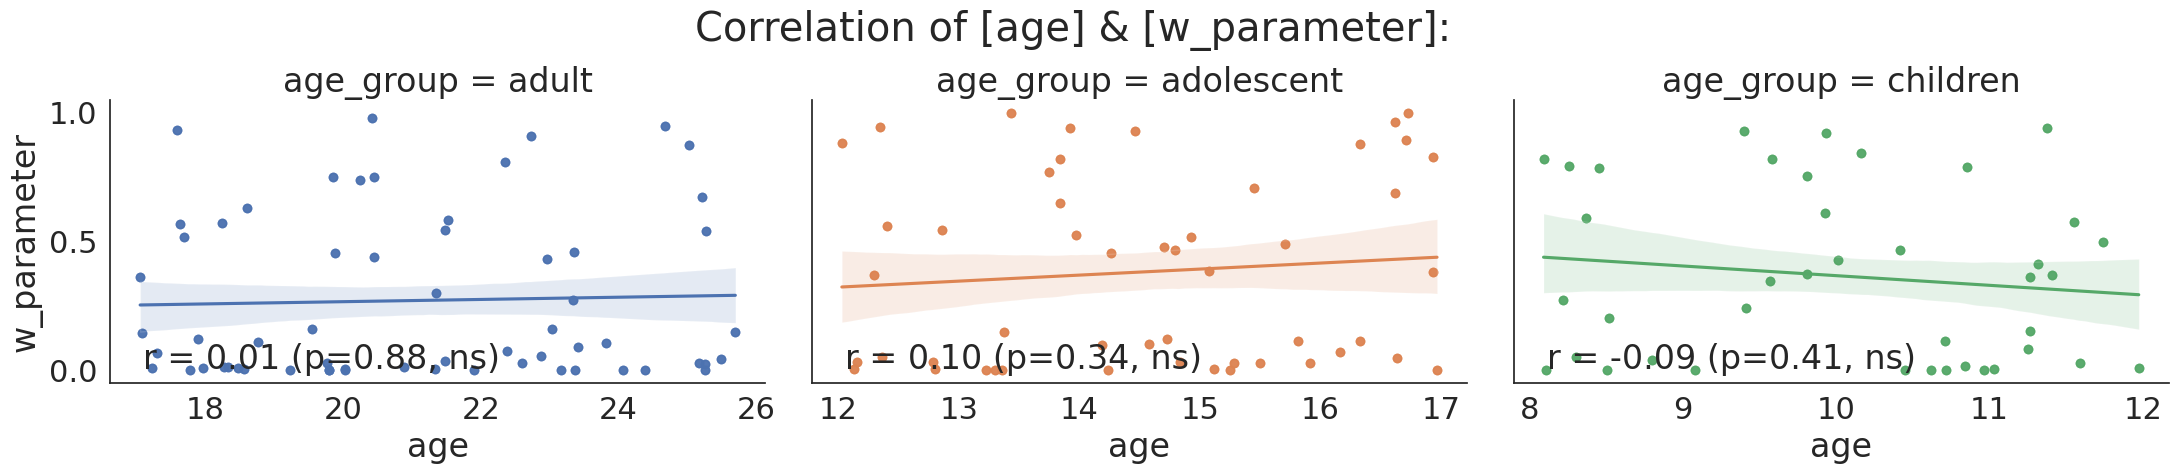

In [24]:
g = sns.lmplot(data=dfm, x=x_name, y=y_name, hue='age_group', col='age_group', height=5, aspect=1.5, facet_kws={'sharex': False})
g.map_dataframe(MarkovPlot.annotate, x=x_name, y=y_name)
g.fig.subplots_adjust(top=.8)   
g.fig.suptitle('Correlation of [%s] & [%s]: ' % (x_name, y_name))
plt.show()